# **Apnea episodes detection using sleep microstructure features in EEG C4 channel in polysomnography**
### E. Polanco Saiz<sup>1</sup>, A.M. Ramírez Márquez<sup>2</sup>

<sup>1</sup>ETSIT, Universidad Rey Juan Carlos, Madrid, España, e.polanco.2017@alumnos.urjc.es

<sup>2</sup>ETSIT, Universidad Rey Juan Carlos, Madrid, España, am.ramirezm.2018@alumnos.urjc.es

## **Abstract**
An algorithm to detect sleep apnea events in EEG signals is
developed. A-phases from the sleep microstructure are segmented
and used to perform the discrimination. It has been shown that
using the duration and the period between A-phases with an
appropriate decision rule the model can achieve a specificity of
89% and a sensibility of 60%.


## **1. Motivation**
Obstructive sleep apnea (OSA) with ICD code G47.33 is a
frequent breathing affection in which the respiratory flow
stops reducing below to 10% of normal levels for at least 10
seconds during sleep [1]. OSA is estimated to affect at least
2% to 4% of people with a rising tendency in the last ten
years. It is more prevalent in men than women and the
prevalence tends to increase with age. Some other OAS
associated factors are obesity, smoking, alcohol, excessive
daytime sleepiness, previous cardiovascular diseases,
diabetes mellitus, etc [2].

OAS can cause oxygen desaturation, daytime sleepiness
and fatigue, among others, leading to long-term
complications that affect the quality of life of those
undiagnosed and therefore untreated patients. In addition to
lifestyle changes, treatments can be classified in the ones
that try to reduce breathing interruptions like PAP therapies,
nasal surgeries, etc. [3]; and the ones that try to increase the
capability to stay asleep like opioid antagonists,
Angiotensin-converting enzyme (ACE) inhibitors, etc.

The evaluation of the last group of treatments leads to the
necessity of creating models that characterize the apnea
event at EEG. Micro-awakening has been shown to be
highly related to the physiology of sleep alterations, this
phenomenon can be isolated or repetitive receiving the
name of cyclic alternating pattern (CAP), this pattern can
be affected due to different factors that alterate its
periodicity potentially offering a quantitative measurement
of the alterations during sleep [4].

The sleep can be divided between NCAP periods and CAP
periods, at the same time, these CAP periods can be divided
between A-phases that are related with these
micro-awakenings and B-phases. Both facts converge in the
interest in segmenting A-phases and evaluate its capacity to
predict apnea episodes.

*Code performed to import libararies used if it is working in google drive, go to the last two cell and install mne and scipy.*

In [4]:
import mne
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import math
from scipy import signal
from numba import jit, cuda
import pandas as pd

*Code to import the PSG while using Google Colab, it should be in the same google drive folder.*

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


## **2. Objectives and study description**
The creation of an algorithm that is able to segment and
characterize A-phases from an EEG. Furthermore, it uses
these features to predict apnea events in the EEG.

The algorithm is developed from a polysomnography (PSG)
made for a study realized at Hospital Universitario de
Mostoles on October 25, 2022. The subject is a woman who
is between 50 and 60 years old and suffers from OSA.

The PSG were recorded with a 24-monopolar-channels
EEG and 14 additional channels including nasal flow
signal. It was recorded with a sampling rate of 256 Hz. The
PSG were processed with a High-Pass filter of 0.15 Hz and
a Low-Pass filter of 67 Hz.

Some annotations of the development of the study were
given, including the opening and closing of the eyes at the
beginning and when the time the subject woke up.


*Code that extracts the file.*

In [6]:
raw_file = '/content/drive/MyDrive/Hospital project/Paciente_sueño.edf'
raw = mne.io.read_raw_edf(raw_file, preload=True)
data = raw.get_data()
info = raw.info
channels = raw.ch_names

Extracting EDF parameters from /content/drive/MyDrive/Hospital project/Paciente_sueño.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7497471  =      0.000 ... 29286.996 secs...


*Code that shows relevant information as the sampling rate, number of channels and its names.*

In [7]:
print('sample rate:', raw.info['sfreq'], 'Hz')
print('Data matrix size : %s channels x %s samples' % (raw.info['nchan'], len(raw.times)))
print('Channel names:', raw.info['ch_names'])

sample rate: 256.0 Hz
Data matrix size : 38 channels x 7497472 samples
Channel names: ['EEG Fp1', 'EEG Fpz', 'EEG Fp2', 'EEG F7', 'EEG F3', 'EEG Fz', 'EEG F4', 'EEG F8', 'EEG T3', 'EEG C3', 'EEG Cz', 'EEG C4', 'EEG T4', 'EEG T5', 'EEG P3', 'EEG Pz', 'EEG P4', 'EEG T6', 'EEG O1', 'EEG Oz', 'EEG O2', 'EEG A1', 'EEG A2', 'EEG elA24', 'TIBI+', 'TIBD+', 'EKG+', 'EOGI+', 'EOGD+', 'ABD+', 'TORX+', 'FLUJ+', 'MENT+', 'RONQ+', 'PULS+', 'BEAT+', 'SpO2+', 'MKR+']


*Code that returns the annotations given.*

In [ ]:
print(mne.events_from_annotations(raw))

Used Annotations descriptions: ['CIERRO PUERTA APAGO LUZ', 'COLOCO SATURIMETRO', 'FIN DE ESTUDIO', 'Ojos Abiertos', 'Ojos Cerrados', 'SAT 94', 'SE LE VA CARDIO ESPERO UN POCO', 'TIB DER', 'TIB IZ']
(array([[    784,       0,       4],
       [   1696,       0,       5],
       [   3696,       0,       5],
       [   4760,       0,       4],
       [   5792,       0,       5],
       [  10824,       0,       4],
       [  11656,       0,       5],
       [  13376,       0,       4],
       [  14288,       0,       5],
       [  15600,       0,       4],
       [  16632,       0,       5],
       [  20232,       0,       5],
       [  22144,       0,       5],
       [  31572,       0,       9],
       [  31867,       0,       8],
       [  92548,       0,       6],
       [  92858,       0,       1],
       [ 649367,       0,       7],
       [6892221,       0,       2],
       [7394035,       0,       3]]), {'CIERRO PUERTA APAGO LUZ': 1, 'COLOCO SATURIMETRO': 2, 'FIN DE ESTUDIO': 3, 'O

## **3. Methodology**
Previous to the development of the algorithm, the apnea
events are obtained from the nasal flow signal. It will allow
the evaluation of the performance of the model.

In the algorithm, the A-phases will be segmented from the
EEG recorded at channel C4. Then, the duration of the
A-phases and they will be characterized by the duration and
the time from the last phases. A simple model based on
thresholding both characteristics is proposed.

### **3.1 Pre-processing**
During the development, two signals will be used. The PSD
of those signals is computed to evaluate if there is some
noise. Nasal flow does not show any noise, however, EEG
C4 shows some noise at 50 Hz caused by the power supply.
So, a notch filter is applied at 50 HZ. It is configured as a
FIR filter with a windowed time-domain designed method
using a Hamming window with 0.0194 passband ripple and
53 dB stopband attenuation.

The signals are chopped from the beginning to time 123.3
seconds to avoid the time the subject falls asleep and from
28883 to the end of the records since it is given the
annotation of the end of the studio.


*Code that computes the PSD of the nasal flow.*

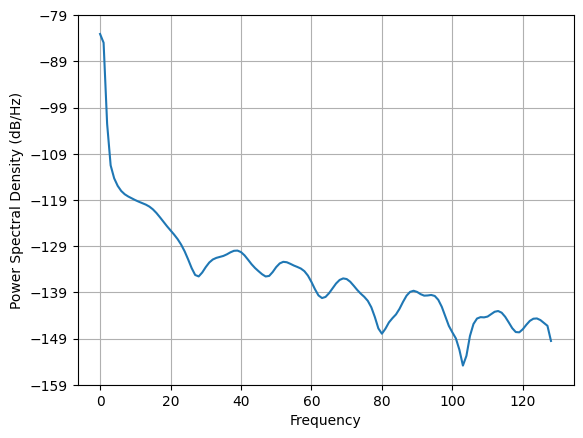

In [8]:
plt.psd(raw['FLUJ+'][0][0], Fs=256)
plt.show()

*Code that computes the PSD of the EEG C4 channel.*

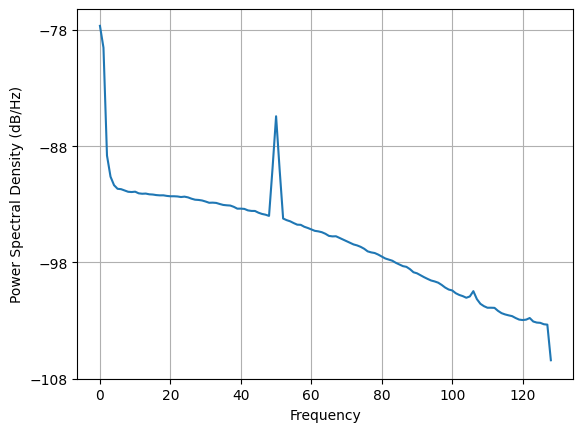

In [9]:
plt.psd(raw['EEG C4'][0][0], Fs=256)
plt.show()

*Code that performs the notch filter.*

In [10]:
raw_filt=raw.notch_filter(50, filter_length='auto', method='fir', fir_window='hamming', fir_design='firwin', verbose=None)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   21.8s finished


*Code that computes the PSD of the EEG C4 channel after the notch filter.*

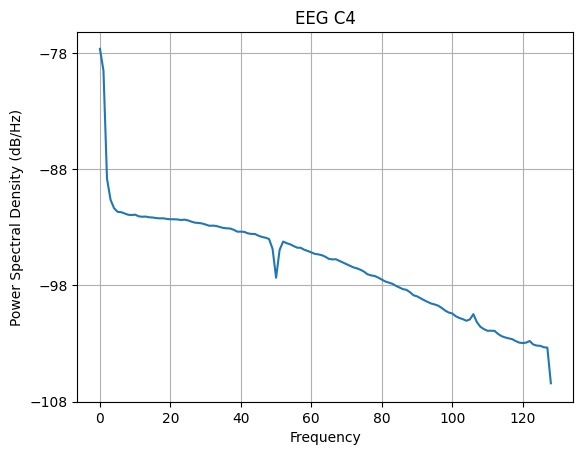

In [ ]:
plt.psd(raw_filt['EEG C4'][0][0], Fs=256)
plt.title('EEG C4')
plt.show()

*Code that chop the signal according to the annotations.*

In [11]:
nsamplei = 31572; nsamplef = 7394035
signal_fluj = raw['FLUJ+'][0][0][nsamplei:nsamplef]

### **3.2 Apnea detection in air flow signal**
Applying the clinical criteria to the nasal flow signal, it is
desired to know where the breath is below 10% of the
baseline value for at least 10 seconds. For this purpose, the
root-mean-square (RMS) with a window of ten seconds [5].

$RMS = \frac{1}{2561} \cdot \sqrt{\sum_{i=1}^{2561}x[i]^{2}} ≈ \frac{\sum_{i=1}^{2561}|x[i]|}{2561}$

A new signal is obtained computing the RMS from the five
seconds from the beginning of the signal and five seconds
before the ending as no padding is used. The baseline
estimation of the signal is obtained by computing the
median to avoid the apnea interference that would be
caused by estimating the baseline with the mean. Then, the
apnea events are calculated as:

$EMS < 𝐵𝑎𝑠𝑒𝑙𝑖𝑛𝑒 \cdot 0. 1$

At this the true values mean that an apnea event has started
five seconds before the first true value and ends five
seconds after the last True values. To compute these values
the signal is interpreted as an integer signal and then
differentiated, being the ones initial event signals five
seconds shifted to the right and the negative ones end event
signals five seconds shifted to the left.

*Code that computes the length of the window ten sevconds multiplu by frequency rate of 256 Hz.*

In [12]:
n = 10*256 + 1

*Code of the function that compute the RMS signal.*

In [ ]:
@jit(target_backend='cuda') 
def rmssNew(flow_signal):
  index = n-1
  lngth = len(flow_signal[n-1: -(n-1)])
  rmsSignalNEW = np.zeros(lngth)
  for i in range(lngth):
    start = index - 5*256 - 1
    end = index + 5*256
    a = np.absolute(flow_signal[start:end])
    a = a.sum()
    rmsSignalNEW[i] = a/n
    index = index + 1
    print(index)
  return(rmsSignalNEW)

*Code that computes the RMS from the nasal flow, since it takes time it has been previously saved and charged at the nexxt cell, so it is not necessary to run this cell.*

In [ ]:
# rmsSignalNew = rmssNew(signal_fluj)

Se han truncado las últimas 5000 líneas del flujo de salida.
7354904
7354905
7354906
7354907
7354908
7354909
7354910
7354911
7354912
7354913
7354914
7354915
7354916
7354917
7354918
7354919
7354920
7354921
7354922
7354923
7354924
7354925
7354926
7354927
7354928
7354929
7354930
7354931
7354932
7354933
7354934
7354935
7354936
7354937
7354938
7354939
7354940
7354941
7354942
7354943
7354944
7354945
7354946
7354947
7354948
7354949
7354950
7354951
7354952
7354953
7354954
7354955
7354956
7354957
7354958
7354959
7354960
7354961
7354962
7354963
7354964
7354965
7354966
7354967
7354968
7354969
7354970
7354971
7354972
7354973
7354974
7354975
7354976
7354977
7354978
7354979
7354980
7354981
7354982
7354983
7354984
7354985
7354986
7354987
7354988
7354989
7354990
7354991
7354992
7354993
7354994
7354995
7354996
7354997
7354998
7354999
7355000
7355001
7355002
7355003
7355004
7355005
7355006
7355007
7355008
7355009
7355010
7355011
7355012
7355013
7355014
7355015
7355016
7355017
7355018
7355019
7355020
735

*Codes that charge the RMS signal from the folder previously created.*

In [19]:
rmsSignalNew = np.fromfile('/content/drive/MyDrive/Hospital project/rmssnew.dat')

*Code that calculate the threshold, apply it to the RMS, gets the event, and shifted. A transformation of dividing it by four is applied since the EEG reduce it resolution when applying spectrogram.*

In [20]:
threshold = np.median(rmsSignalNew)*0.1
apnea_event = rmsSignalNew< threshold
apnea_event = apnea_event.astype(int)
Event_signal = np.diff(apnea_event)
Initial_event_signal = np.where(Event_signal == 1)
End_event_signal = np.where(Event_signal == -1)
Initial_event_signal = Initial_event_signal[0]/4 - 3920
End_event_signal = End_event_signal[0]/4 + 3920

*Code to establish coherence since to mooving average filter has been applies at preprocessing, it is needed to avoid split events detection.*

In [21]:
ISD = [False]
IED = []
for i in range(1, len(Initial_event_signal)):
  if Initial_event_signal[i] < End_event_signal[i-1]:
    ISD.append(True)
    IED.append(True)
  else:
    ISD.append(False)
    IED.append(False)
IED.append(False)
Initial_event_signal = np.delete(Initial_event_signal, ISD, axis=0)
End_event_signal = np.delete(End_event_signal, IED, axis=0)

### **3.3 A-phases segmentation**
In parallel, the evaluation of the sleep microstructure starts
with the segmentation of the A-phases. Different methods
had been proposed to archive the CAP features. We use a
method proposed by Barcaro et al [4]. that allows the
quantitative description of sleep microstructure through the
A-phases segmentation.

The method relies on the computation of some frequency
descriptors. So as a first step the spectrogram of the EEG
signal is computed. The parameters of the spectrogram are
a window of 128 segments with an overlapping of 124
segments leading to a loss of resolution from 256 segments
per second to 64 segments per second.

Then, two mean amplitudes in the frequency band of 1-4Hz
are computed, one over a time of two seconds that is
closely related to the sleep microstructure and a second one
over a time of 64 seconds that is closely related to the sleep
macrostructure. Then the descriptor is computed as:

$\mu_{δ}(t)=\frac{C_{\delta,2} - C_{\delta,64}}{C_{\delta,64}}$

From this descriptor, A-phases can be segmented by
applying two threshold µ(𝑡) ≻ 0 is used to obtain the
length of the A-phases and µ(𝑡) ≻ 1 is used to classify the
A-phases.

To perform the segmentation the first signal is processed in
a similar way than 3.2 but taking into account that the time
shift is greater since a window of 64 seconds is being used.
A second step is added to avoid classifying false A-phases,
only keeping those one that at some point reaches one. So,
they are evaluated at the second threshold and they are kept
if the sum of the segmented period in the second threshold
signal is greater than one.


*Code that computes the spectrogram.*

In [22]:
nsamplei = 31572; nsamplef = 7394035
x =  raw_filt['EEG C4'][0][0][nsamplei:nsamplef]
f, t, Zxx = signal.spectrogram(x, 256, nperseg=128, noverlap=124)

*Codes that computes the bend power, then the mean power $C_{\delta,2}$ and $C_{\delta,64}$, finallt computes  µ(𝑡).*

In [23]:
C14 = np.zeros(len(t))
for i in range(len(t)):
  C14[i] = Zxx[1][i]+Zxx[2][i]
C142 = np.zeros(len(C14)-127)
for i in range(64, len(t)-64):
  C142[i-64] = np.mean(C14[i-64:i+64])
C1460 = np.zeros(len(C14)-3839)
for i in range(1920, len(t)-1920):
  C1460[i-1920] = np.mean(C14[i-1920:i+1920])
C14260 = np.zeros(len(C1460))
for i in range(len(C1460)):
  C14260[i] = C142[i+1856]/C1460[i] - 1

<ipython-input-23-20e7ee786ae9>:12: RuntimeWarning: divide by zero encountered in double_scalars
  C14260[i] = C142[i+1856]/C1460[i] - 1


*Code that performs both threshold and obtain the candidate limits from the first one. The signal is fixed if it started with a candidate it detects it.*

In [24]:
EventC14 = C14260 > 1
EventC14 = EventC14.astype(int)
PeriodC14 = C14260 > 0
PeriodC14 = PeriodC14.astype(int)
PeriodC14[0] = 0
PeriodC14[-1] = 0
PeriodC14 = np.diff(PeriodC14)
IndexC14 = np.where(PeriodC14==1)[0] - 1920
IndexC14End = np.where(PeriodC14==-1)[0] - 1920

*Code that discriminate the A-phases by evaliating with the threshold one signal.*

In [25]:
IndexAPhaseStart = []
IndexAPhaseEnd = []
a = 0
for i in range(len(IndexC14)):
  if np.sum(EventC14[int(IndexC14[i]):int(IndexC14End[i])])>1:
    IndexAPhaseStart.append(int(IndexC14[i]))
    IndexAPhaseEnd.append(int(IndexC14End[i]))
    a = a+1
IndexAPhaseStart = np.array(IndexAPhaseStart)
IndexAPhaseEnd = np.array(IndexAPhaseEnd)

*Code that concatenate both apnea events and A-phases to be able to iterate them sequentially.*

In [26]:
IndexStarts = np.concatenate((IndexAPhaseStart, Initial_event_signal), axis=0)
IndexStarts = np.sort(IndexStarts)
IndexEnd = np.concatenate((IndexAPhaseEnd, End_event_signal), axis=0)
IndexEnd = np.sort(IndexEnd)

### **3.4 Feature extraction and model set up**
Those A-phases can be characterized by the duration and
the time between phases. For that purpose the duration is
calculated as the sample the phase end minus the sample
the phase start. The time between phases is calculated as the
time the phase starts minus the time the last phase ends. In
the case of the first phase the last phase end is considered
the zero. Then, the duration and the time between phases
are divided by 64 to return the feature to seconds. In the
case of the time between phases the first derivative is also
considered.

The A-phases characterized show information about what is
happening with microstructure. Since abrupt rupture of the
sleep microstructure are connected with alteration during
sleep phases much shorter than normal and with a reduction
of interphase larger than normal are found.

The model proposed, set A-phases with a duration shorter
than one second and with a change of interphase given by
the first derivative of the interphase lower than 200.

*Code that computes the duration of the A-phases and the InterPhases.*

In [27]:
Duration = IndexAPhaseEnd/64 - IndexAPhaseStart/64
InterPhase = np.zeros(len(Duration))
InterPhase[0] = IndexAPhaseStart[0]/64
InterPhase[1:] = IndexAPhaseStart[1:]/64 - IndexAPhaseEnd[:-1]/64

*Code that computes the first derivative of the InterPhases.*

In [28]:
InterPhased1=np.zeros(len(InterPhase))
InterPhased1[1:] = np.diff(InterPhase)

## **4. Results**
### **4.1 Air flow signal apneas results**
The nasal air flow signal shows that the patient has suffered
six apnea events during the study and hypopneas are not
calculated as they are not under consideration.

Since preprocessing with a moving average filter has not
been done with the nasal air flow signal, coherence post
processing is needed as an event can be split in more than
one by small abrupt increase of the RMS signal. Initial
results show nine events but two of them were split events.

As can be seen in Table 1 the apnea events last between
125 seconds and 168 seconds. Four of them last less
than 130 seconds. Regarding the post processing one
was interpreted as two and another one as three.

*Code that generates Table 1.*

In [39]:
Apneas = {'Start':Initial_event_signal, 'End':End_event_signal, 'Duration':(End_event_signal-Initial_event_signal)/64}
Apneas = pd.DataFrame(data=Apneas)
Apneas

,Start,End,Duration
0,531351.75,539931.50,134.058594
1,572719.50,580753.00,125.523438
2,1378536.00,1386588.75,125.824219
3,1602563.50,1610667.25,126.621094
4,1712368.25,1720589.25,128.453125
5,1740419.75,1751159.25,167.804688


### **4.2 A-phases results**
After computing the descriptor, there were 3358 candidate
segments of which 169 resulted in an A-phase. The mean
duration of the A-phases was 2.55 seconds with a standard
deviation of 1.88 seconds. The mean duration of the period
between phases was 165.9 seconds with a standard
deviation of 220.7 seconds.

From figure 1, it is seen that short duration A-phases,
subject of interest at this work, are well characterized by a
short duration while interphase duration is better
discriminated by abrupt reduction in the change of the
interphase.

*Code where the statistics are computed.*

In [40]:
print('Candidate segments for A-phases ', len(IndexC14))
print('Final A-phases', len(IndexAPhaseStart))
print('Mean duration', np.mean(Duration))
print('Standard deviation of A-phases', np.std(Duration))
print('Mean InterPhase', np.mean(InterPhase))
print('Standard deviation of InterPhase', np.std(InterPhase))

Candidate segments for A-phases  6358
Final A-phases 169
Mean duration 2.5568602071005917
Standard deviation of A-phases 1.887218640802102
Mean InterPhase 165.9017196745562
Standard deviation of InterPhase 220.7381279836948


*Code that created figure one, duration depending on the position.*

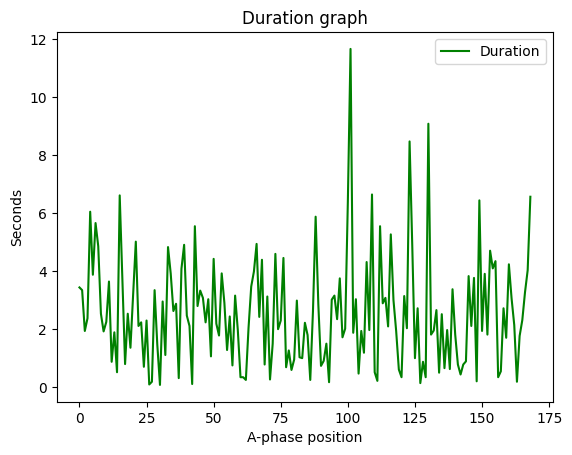

In [30]:
plt.figure()
plt.plot(range(len(Duration)), Duration, label='Duration', color='g')
plt.xlabel('A-phase position')
plt.ylabel('Seconds')
plt.title('Duration graph')
plt.legend()
plt.show()

*Code that created figure 2, InterPhase and InterPhase change depending on its position.*

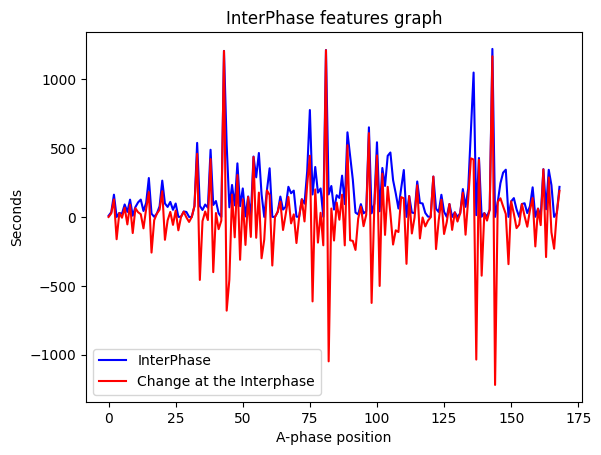

In [31]:
plt.figure()
plt.plot(range(len(InterPhase)), InterPhase, label='InterPhase', color='b')
plt.plot(range(len(InterPhased1)), InterPhased1, label='Change at the Interphase', color='r')
plt.xlabel('A-phase position')
plt.ylabel('Seconds')
plt.title('InterPhase features graph')
plt.legend()
plt.show()

### **4.3 Model evaluation**
In order to evaluate the model it is necessary at first
instance to determine which A-phases can be considered
candidates to be predictive of an apnea. The criteria
established is that an A-phase can predict an apnea if it
appears during the apnea or if it is one of the two phases
that goes right after the end of the apnea.

Defining the specificity as the probability of an A-phase
that does not correspond to an apnea showing in the model
that an apnea event is not associated. 109 phases results in
no apnea detection of which 98 does not match with any
apnea leading to an specificity of 0.89.

Defining the sensibility as the probability of an A-phase
that does correspond to an apnea showing in the model that
an apnea event is associated. 5 phases results in apnea
detection of which 3 match with any apnea leading to an
sensibility of 0.6.

The sensibility shows that the A-phase segmentation and
the decision model are a robust criteria for discriminating
Apnea effects in the EEG. At the specificity, it is observed
that there are few phases that follow the same
microstructure break. That agrees with the literature since
sleep microstructure can be altered by other awakening
events and other sleep disorders.

Therefore, further research is needed to discriminate
between these awakening events and other sleep disorders.
Also, it is needed to go deep in the criteria to establish and
generalize the decision model.

*Code that assigns apnea possible predictor to the corresponding A-phases, also iterate and shows both kind of segments for visual purposes.*

In [35]:
a = 0
b = 0
Apnea = False
ApneaList = np.zeros(len(IndexAPhaseStart))
for i in range(len(IndexEnd)-1):
  last = 0
  if IndexEnd[i] in End_event_signal:
    print('Apnea event that begins at {} and finish at {} and last {} seconds.'.format(Initial_event_signal[b], End_event_signal[b], (End_event_signal[b]-Initial_event_signal[b])/64))
    b = b+1
    Apnea = True
  else:
    lima = int(IndexAPhaseStart[a])
    limb = int(IndexAPhaseEnd[a])
    print('Phase A that begins at {} and finish at {}, last {} seconds.'.format(lima,limb,(limb-lima)/64))
    print(InterPhased1[a])
    a = a+1
    if Apnea:
        ApneaList[a] = b
        ApneaList[a+1] = b
        Apnea = False
    if Apnea==False and b<6:
      if lima>Initial_event_signal[b] and lima<End_event_signal[b]:
          ApneaList[a] = b

Phase A that begins at 533 and finish at 753, last 3.4375 seconds.
0.0
Phase A that begins at 2966 and finish at 3180, last 3.34375 seconds.
26.25
Phase A that begins at 13533 and finish at 13657, last 1.9375 seconds.
127.1875
Phase A that begins at 13658 and finish at 13810, last 2.375 seconds.
-161.75
Phase A that begins at 15656 and finish at 16043, last 6.046875 seconds.
28.828125
Phase A that begins at 17532 and finish at 17780, last 3.875 seconds.
-5.578125
Phase A that begins at 23583 and finish at 23945, last 5.65625 seconds.
67.40625
Phase A that begins at 26291 and finish at 26602, last 4.859375 seconds.
-54.015625
Phase A that begins at 34658 and finish at 34820, last 2.53125 seconds.
89.21875
Phase A that begins at 35392 and finish at 35515, last 1.921875 seconds.
-116.9375
Phase A that begins at 40114 and finish at 40258, last 2.25 seconds.
62.921875
Phase A that begins at 47045 and finish at 47278, last 3.640625 seconds.
34.1875
Phase A that begins at 55344 and finish at 

*Code that generates a data frame with the A-phases, both characteristics, and the apnea episodes that could be predictive, if it should not be predictive any apnea episodes zero is the value.*

In [46]:
d = {'Duration': Duration, 'InterPhase derivative': InterPhased1, 'Apnea':ApneaList}
df = pd.DataFrame(data=d)
df

,Duration,InterPhase derivative,Apnea
0,3.437500,0.000000,0.0
1,3.343750,26.250000,0.0
2,1.937500,127.187500,0.0
3,2.375000,-161.750000,0.0
4,6.046875,28.828125,0.0
...,...,...,...
164,1.765625,286.640625,6.0
165,2.312500,-111.390625,0.0
166,3.265625,-230.640625,0.0
167,4.031250,28.203125,0.0


*Code that computes the specifity, dfSpe is the DataFrame with the non-selected segments.*

In [48]:
dfSpe = df[df['Duration']>0.9]
dfSpe = dfSpe[dfSpe['InterPhase derivative']>-200]
print('Specifity: ', dfSpe[dfSpe['Apnea']==0].count()[0]/dfSpe.count()[0])
print('Segments that are not predicting any apnea at the data frame: ', dfSpe[dfSpe['Apnea']==0].count()[0])
print('Total number of segments at the data frame: ', dfSpe.count()[0])

Specifity:  0.8990825688073395
Segments that are not predicting any apnea at the data frame:  98
Total number of segments at the data frame:  109


*Code that computes the sensibility, dfSen is the DataFrame with the selected segments.*

In [50]:
dfSen = df[df['Duration']<0.9]
dfSen = dfSen[dfSen['InterPhase derivative']<-200]
print('Sensibility: ', dfSen[dfSen['Apnea']!=0].count()[0]/dfSen.count()[0])
print('Segments that are predicting an apnea at the data frame: ', dfSen[dfSen['Apnea']!=0].count()[0])
print('Total number of segments at the data frame: ', dfSen.count()[0])

Sensibility:  0.6
Segments that are predicting an apnea at the data frame:  3
Total number of segments at the data frame:  5


*Code that generated table 2.*

In [44]:
dfSen

,Duration,InterPhase derivative,Apnea
57,0.750000,-300.031250,0.0
61,0.343750,-352.734375,1.0
111,0.218750,-340.515625,0.0
144,0.890625,-1220.031250,4.0
163,0.187500,-291.296875,6.0


## **4. Conclusions**
At this work, it has been shown the feasibility of using the
A-phase segmentation method proposed by Barcaro et al
[4]. to detect Apnea events in EEG signals.


## **Acknowledgments**
Finally, we would like to thank physician Eduardo Gómez
Utrero from Neurophysiology department of Hospital
Universitario de Móstoles and Rebeca Goya Esteban from
Rey Juan Carlos University for giving us the opportunity to
develop the project and giving us guidance.


## **References**
[1] What Is Sleep Apnea? | NHLBI, NIH. (2022, 24 marzo).
NHLBI, NIH. https://www.nhlbi.nih.gov/health/sleep-apnea

[2] Franklin, K. A., & Lindberg, E. (2015). Obstructive sleep
apnea is a common disorder in the population-a review on the
epidemiology of sleep apnea. Journal of Thoracic Disease,
7(8), 1311-1322.
https://doi.org/10.3978/j.issn.2072-1439.2015.06.11

[3] Pavwoski, P., & Shelgikar, A. V. (2017). Treatment options
for obstructive sleep apnea. Neurology, 7(1), 77-85.
https://doi.org/10.1212/cpj.0000000000000320

[4] Barcaro, U., Navona, C., Belloli, S., Bonanni, E., Gneri, C.,
& Murri, L. (1998). A simple method for the quantitative
description of sleep microstructure. Electroencephalography
and Clinical Neurophysiology.
https://doi.org/10.1016/s0013-4694(98)00008-x

[5] Sierra, D. F. C., León, M. C., & Casallas, L. H. C. (2017).
Identificación automática de episodios de SAHS utilizando
señales de poligrafía respiratoria. Revista Colombiana de
Psiquiatría. https://doi.org/10.1016/j.rcp.2016.04.005

In [2]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 34.1 MB/s eta 0:00:00
